## Cellpose trained to learn scale

This example shows how to train cellpose to find objects at different scales.  We try to use the same cellpose model to detect several spheres of varying sizes in the same image. 

When applying a cellpose model to an image, it is common to use the 'diameter' parameter to rescale image to detect structure at a different scale than the network was trained for.  However this may not work if single images have objects at different scales within the image. 

If the training data has a mixture of small and large objects, cellpose can learn these but we may need to "de-activate" the auto scaling.   This can be shown with a simple simulation.  

In [85]:
import raster_geometry as rg
import numpy as np
from tnia.simulation.phantoms import add_small_to_large_2d
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d, imshow2d
import math

## Make a super simple fake dataset

Here we add a few different objects of different sizes.

To create a training set we a keep a copy of the single spheres (which are put in 224 by 224 arrays by raster geometry... perfect for training patches)

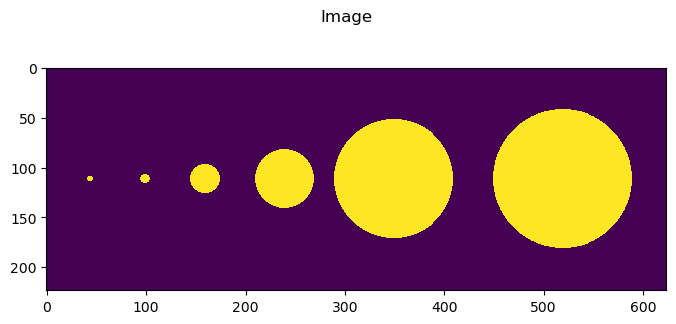

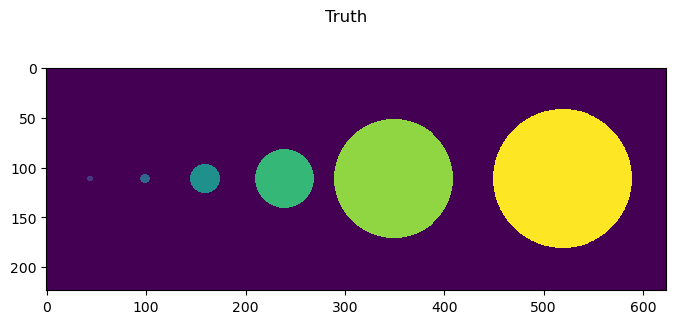

In [86]:


width, height = 624, 224

image = np.zeros([height, width], dtype=np.float32)
truth = np.zeros([height, width], dtype=np.float32)

rs = [3, 5, 15, 30, 60, 70]

x_ = 44

# for train will be a list of the 224 by 224 circle images that will be used for training
for_train = []

i = 1 
for r in rs:
    x, y = x_, 112
    size = [math.ceil(r*2), math.ceil(r*2)]
    size = [224, 224]
    temp=rg.circle(size, r)
    for_train.append(temp)
    add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
    add_small_to_large_2d(truth, i*temp, x, y, mode='replace_non_zero')
    x_ = x_ + 50+2*r
    i += 1

fig = imshow2d(image, width = 8, height = 3.5)
# set title
fig.suptitle('Image')
fig = imshow2d(truth, width=8, height=3.5)
# set title
stop = fig.suptitle('Truth')

## Load Cyto2

We also print the mean diameter of cyto2 (if log is on this will print by default too)

In [87]:
from cellpose import models, io
model_cyto2 = models.CellposeModel(gpu=True, model_type="cyto2")

print('cyto3 diameter mean', model_cyto2.diam_mean)
print('cyto2 diameter labels', model_cyto2.diam_labels)

2025-04-24 09:17:04,501 [INFO] >> cyto2 << model set to be used
2025-04-24 09:17:04,505 [INFO] ** TORCH CUDA version installed and working. **
2025-04-24 09:17:04,506 [INFO] >>>> using GPU (CUDA)
2025-04-24 09:17:04,621 [INFO] >>>> loading model C:\Users\bnort\.cellpose\models\cyto2torch_0
2025-04-24 09:17:04,782 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
cyto3 diameter mean 30.0
cyto2 diameter labels 30.0


Note that we can change the mean diameter when initializing a model. 

**diam_mean** this acts as a reference.  During training images will be rescaled to this value. During prediction this value will be used as a reference for the rescaling value.  For example if ```diam_mean``` is 60, and if ```diameter``` passed to ```eval``` is 120 then the image will be scaled by ```diam_mean```/```diameter=60/120=0.5```

In [88]:
model_cyto2_60 = models.CellposeModel(gpu=True, model_type="cyto2", diam_mean=60)

print('cyto3 diameter mean', model_cyto2_60.diam_labels)
print('cyto2_60 diameter labels', model_cyto2_60.diam_labels)

2025-04-24 09:17:42,613 [INFO] >> cyto2 << model set to be used
2025-04-24 09:17:42,616 [INFO] ** TORCH CUDA version installed and working. **
2025-04-24 09:17:42,617 [INFO] >>>> using GPU (CUDA)
2025-04-24 09:17:42,723 [INFO] >>>> loading model C:\Users\bnort\.cellpose\models\cyto2torch_0
2025-04-24 09:17:42,974 [INFO] >>>> model diam_mean =  60.000 (ROIs rescaled to this size during training)
cyto3 diameter mean 60.0
cyto2_60 diameter labels 60.0


## Process with Cyto2 with different diameters 

We try a few different diameters to see if we can find all the objects. Unfortunately there is no diameter value that works for everything. 

It looks like d=6 finds the small objects, d=140 finds the big one, and default finds only a medium one. 

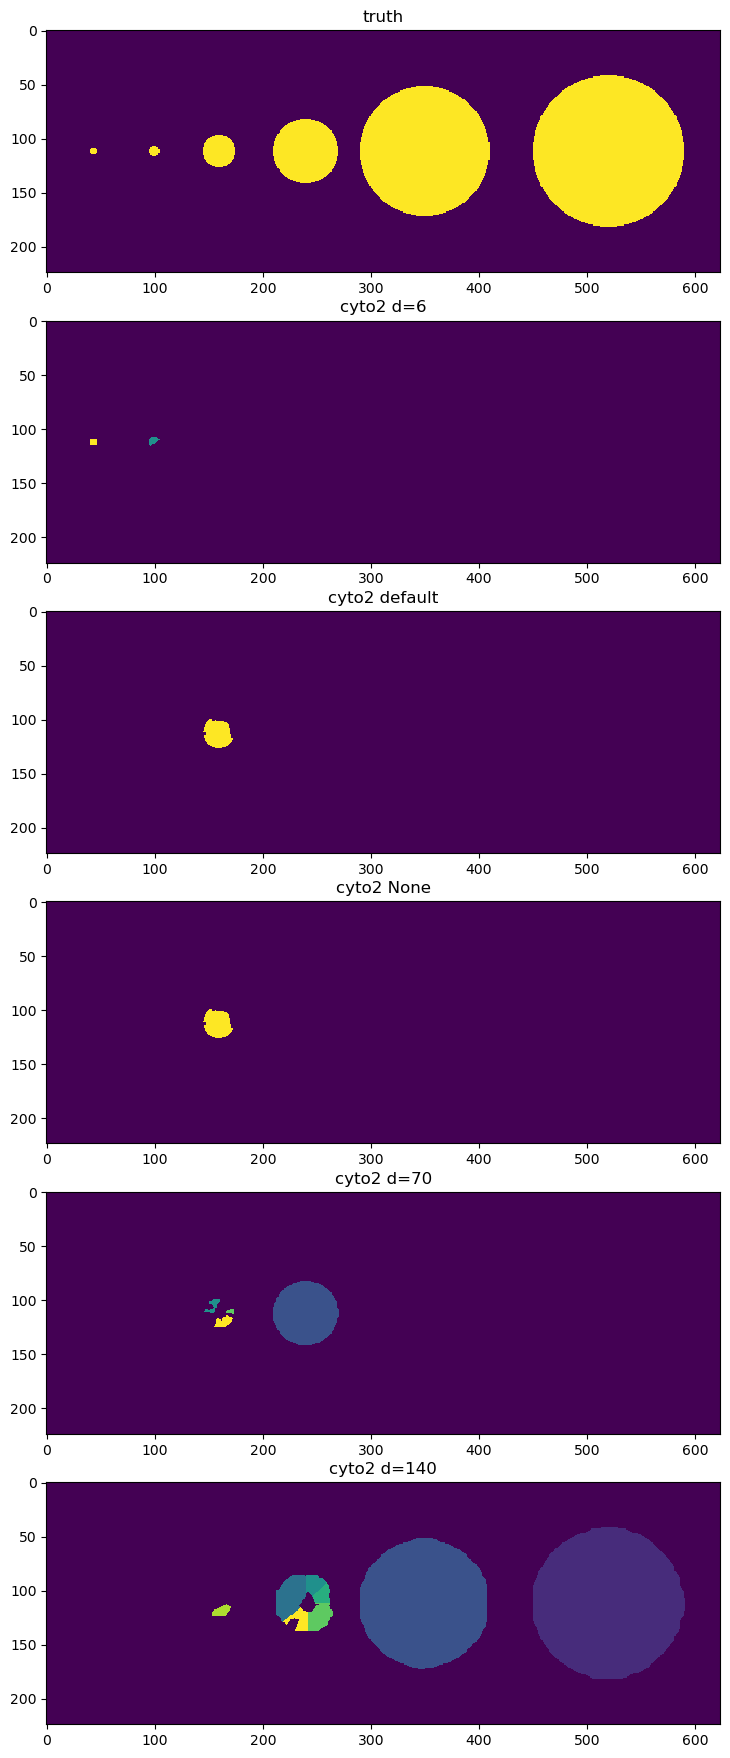

In [89]:

flow_threshold = 0
cellprob_threshold = -0.8

labels_d6 = model_cyto2.eval(image, channels=[0, 0],diameter=6,flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
labels_default = model_cyto2.eval(image, channels=[0, 0], flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
labels_none = model_cyto2.eval(image, channels=[0, 0], diameter = None, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
labels_d70 = model_cyto2.eval(image, channels=[0, 0],diameter=70,flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
labels_d140 = model_cyto2.eval(image, channels=[0, 0],diameter=140,flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)[0]
fig = imshow_multi2d([image, labels_d6, labels_default, labels_none, labels_d70, labels_d140], ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 None', 'cyto2 d=70','cyto2 d=140'], 6 ,1, width = 12, height = 22)



## Repeat the objects to make a fake training set

Just repeat a few times to make a trivial training set.  No need to even add blur or noise, we just want to see if a custom model can learn different scales. 

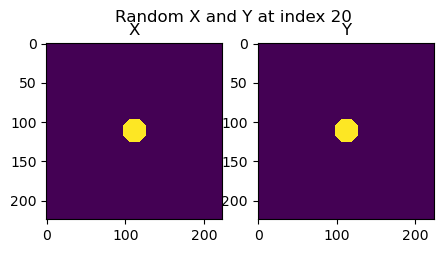

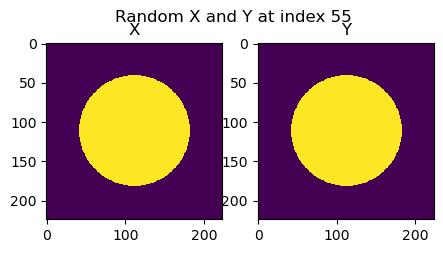

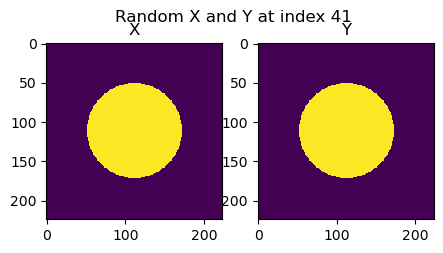

In [90]:
X = []
Y = []
for train in for_train:
    X = X+[train.copy().astype('float32')[..., np.newaxis] for i in range(10)]
    Y = Y+[train.copy().astype('uint16') for i in range(10)]

len(X)

# show a few X,Y pairs to see if they look right 
import random
def show_rand_XY():
    i = random.randint(0, len(X)-1)
    fig = imshow_multi2d([X[i], Y[i]], ['X', 'Y'], 1 ,2, width = 5, height = 2.5)
    fig.suptitle(f'Random X and Y at index {i}')
    return fig

fig = show_rand_XY()
fig = show_rand_XY()
fig = show_rand_XY()


## Make a custom model

In [75]:
import os

model_path = r'./'
model_name = 'custom'
logger = io.logger_setup()
model_custom = models.CellposeModel(gpu=True, model_type=None)

creating new log file
2025-04-24 09:08:54,307 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2025-04-24 09:08:54,308 [INFO] 
cellpose version: 	3.1.0 
platform:       	win32 
python version: 	3.11.11 
torch version:  	2.6.0
2025-04-24 09:08:54,311 [INFO] ** TORCH CUDA version installed and working. **
2025-04-24 09:08:54,312 [INFO] >>>> using GPU (CUDA)
2025-04-24 09:08:54,472 [INFO] >>>> no model weights loaded


## Train our custom model

Note our fake training set was trivial, a set of images each containing single circle ranging from large circles to small.

However I found that in order to learn this very simple data, we need to explicitly set 'rescale' to False when training.

Otherwise the images are rescaled during the training process, and we don't actually learn the different scales. 

In [77]:
from cellpose import train

print('mean diam', model_custom.diam_mean)
print('diam labels', model_custom.diam_labels)

test=train.train_seg(model_custom.net, X, Y, 
    channels=[0,0], 
    save_path=model_path, 
    n_epochs=150,
    min_train_masks=1,
    normalize = False,
    rescale = False,  
    model_name=model_name)

print()
print('mean diam', model_custom.diam_mean)
print('diam labels', model_custom.diam_labels)

mean diam 30.0
diam labels 30.0
2025-04-24 09:09:59,143 [INFO] computing flows for labels


100%|██████████| 60/60 [00:03<00:00, 16.47it/s]

2025-04-24 09:10:02,796 [INFO] >>> computing diameters



100%|██████████| 60/60 [00:00<00:00, 3749.88it/s]

2025-04-24 09:10:02,816 [INFO] >>> using channels [0, 0]
2025-04-24 09:10:02,830 [INFO] >>> n_epochs=150, n_train=60, n_test=None
2025-04-24 09:10:02,831 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2025-04-24 09:10:02,833 [INFO] >>> saving model to models\custom


2025-04-24 09:10:03,662 [INFO] 0, train_loss=0.0135, test_loss=0.0000, LR=0.000000, time 0.83s
2025-04-24 09:10:07,479 [INFO] 5, train_loss=0.0526, test_loss=0.0000, LR=0.002778, time 4.65s
2025-04-24 09:10:11,309 [INFO] 10, train_loss=0.0339, test_loss=0.0000, LR=0.005000, time 8.48s
2025-04-24 09:10:18,882 [INFO] 20, train_loss=0.0334, test_loss=0.0000, LR=0.005000, time 16.05s
2025-04-24 09:10:26,520 [INFO] 30, train_loss=0.0227, test_loss=0.0000, LR=0.005000, time 23.69s
2025-04-24 09:10:34,156 [INFO] 40, train_loss=0.0139, test_loss=0.0000, LR=0.005000, time 31.32s
2025-04-24 09:10:41,848 [INFO] 50, train_loss=0.0540, test_loss=0.0000, LR=0.005000, time 39.02s
2025-04-24 09:10:49,512 [INFO] 60, train_loss=0.0163, test_loss=0.0000, LR=0.005000, time 46.68s
2025-04-24 09:10:57,342 [INFO] 70, train_loss=0.0109, test_loss=0.0000, LR=0.005000, time 54.51s
2025-04-24 09:11:05,076 [INFO] 80, train_loss=0.0105, test_loss=0.0000, LR=0.005000, time 62.24s
2025-04-24 09:11:12,977 [INFO] 90, 

## Reload to see diameter of labels

For some reason we seem to have to reload to see the proper diameter of the training labels

In [78]:
model_custom= models.CellposeModel(gpu=True, pretrained_model=os.path.join(model_path, 'models', model_name))
print('reloaded diam mean', model_custom.diam_mean)
print('reloaded diam labels', model_custom.diam_labels)

2025-04-24 09:12:04,784 [INFO] ** TORCH CUDA version installed and working. **
2025-04-24 09:12:04,785 [INFO] >>>> using GPU (CUDA)
2025-04-24 09:12:04,879 [INFO] >>>> loading model ./models\custom
2025-04-24 09:12:05,116 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-24 09:12:05,117 [INFO] >>>> model diam_labels =  61.097 (mean diameter of training ROIs)
reloaded diam mean 30.0
reloaded diam labels 61.096962


## Call eval with several different diameters

1.  Do not pass diameter
2.  Pass ```diameter=0```
3.  Pass ```diameter=None```
4.  Pass ```diameter=model_custom.diam_mean```
5.  Pass ```diameter=model_custom.diam_labels```

In [91]:
labels_custom, c, d = model_custom.eval(image, channels=[0, 0], normalize = False)
labels_custom_diameter_0, c_0, d_0 = model_custom.eval(image, channels=[0, 0], diameter=0, normalize = False)
labels_custom_diameter_none, c_none, d_none = model_custom.eval(image, channels=[0, 0], diameter=None, normalize = False)
labels_custom_diameter_mean, c_mean, d_mean = model_custom.eval(image, channels=[0, 0], diameter=model_custom.diam_mean, normalize = False)
labels_custom_diameter_labels, c_labels, d_labels = model_custom.eval(image, channels=[0, 0], diameter=model_custom.diam_labels, normalize = False)

truth.sum(), labels_custom.sum()

(162452.0, 49510)

## Show all the cyto labels and label custom

Note: cyto can only find objects of different sizes by tuning the ```diameter``` param.  Custom can find very different object sizes by default. 

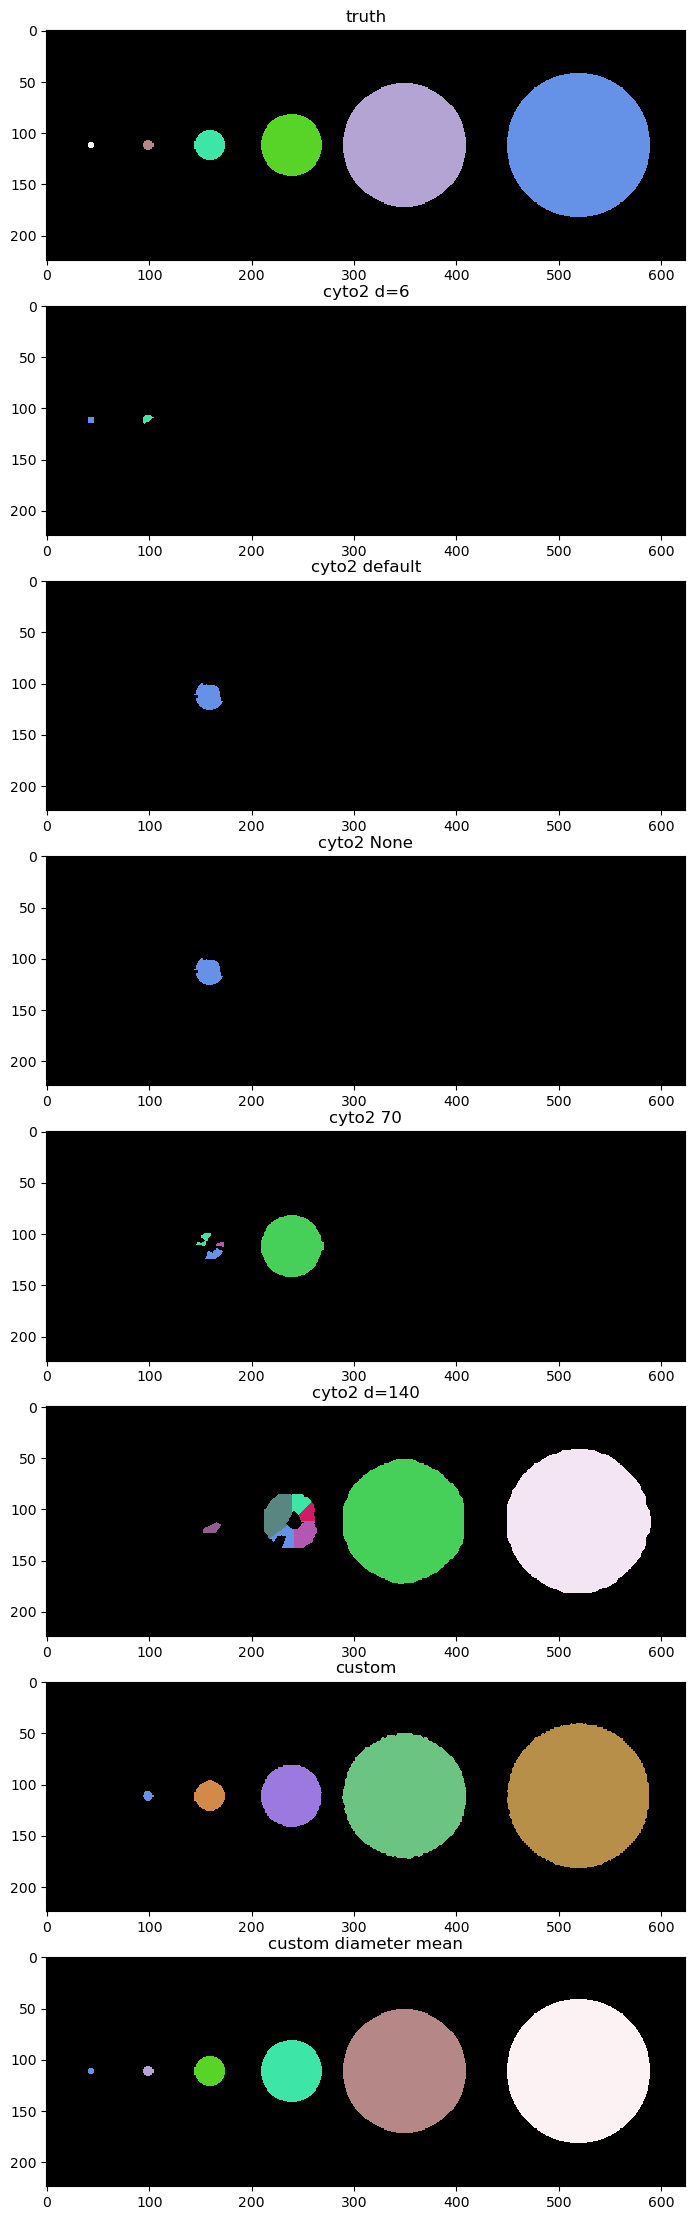

In [92]:
import random
from tnia.plotting.plt_helper import random_label_cmap

cmaps = [random_label_cmap()]*9

fig = imshow_multi2d([truth, labels_d6, labels_default, labels_none, labels_d70, labels_d140, labels_custom, labels_custom_diameter_mean], 
                     ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 None', 'cyto2 70', 'cyto2 d=140', 'custom', 'custom diameter mean'],8 ,1, width = 12, height = 28, colormaps=cmaps)

## Show custom model results 

Below we show the results of ```custom_model.eval``` using different diameters

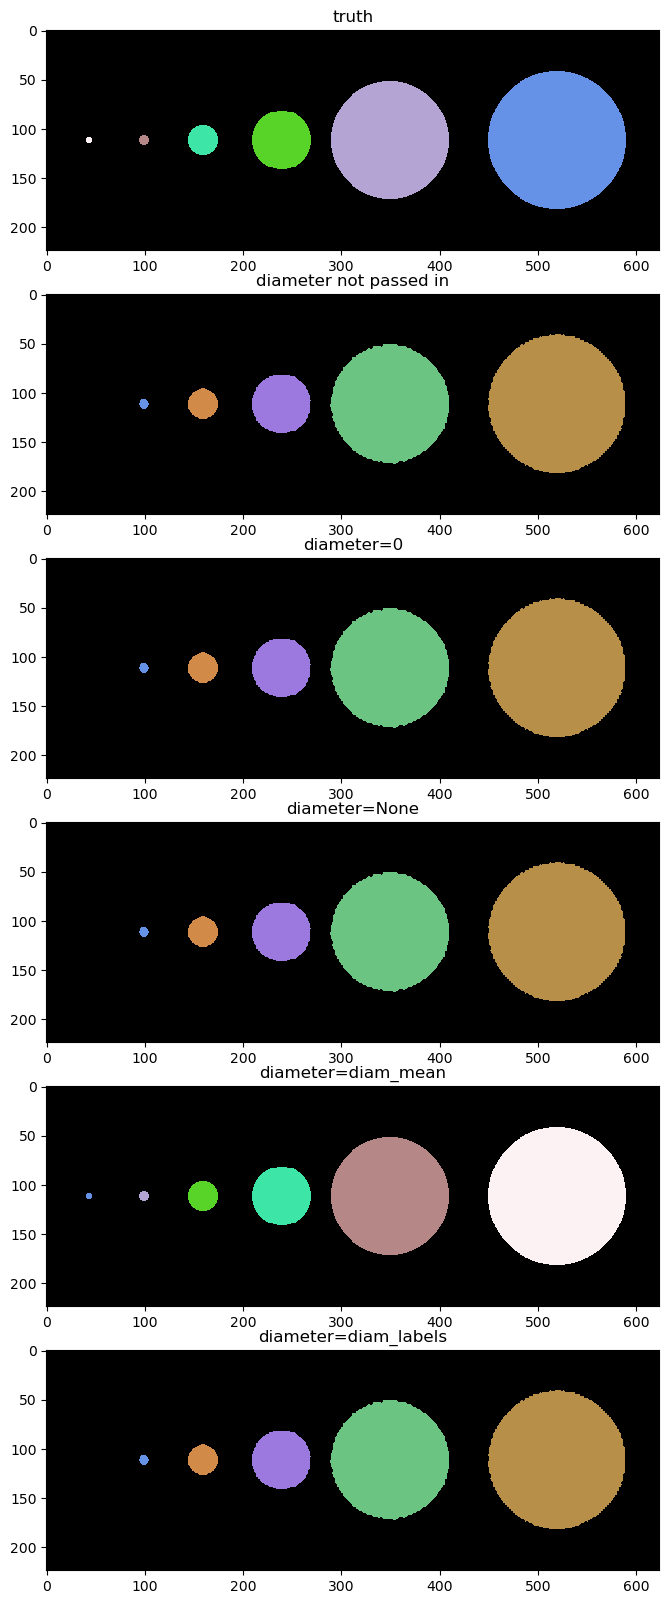

In [95]:
fig = imshow_multi2d([truth, labels_custom, labels_custom_diameter_0, labels_custom_diameter_none, labels_custom_diameter_mean, labels_custom_diameter_labels], ['truth', 'diameter not passed in', 'diameter=0', 'diameter=None', 'diameter=diam_mean', 'diameter=diam_labels'], 6 ,1, width = 12, height = 20, colormaps=cmaps)

## Look at flows

Text(0.5, 1.0, 'flows')

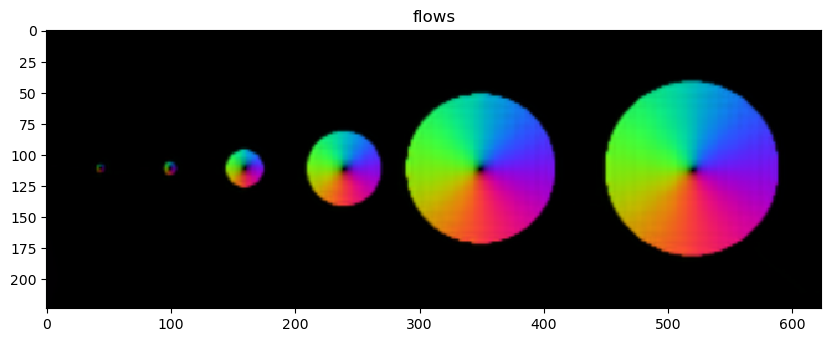

In [94]:
plt.figure(figsize=(10,10))
plt.imshow(c[0])
plt.title('flows')